<a href="https://colab.research.google.com/github/Illiaklyuyev/Arcanoid-V1/blob/main/taskCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import torch

In [10]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [11]:
from torchvision import datasets
from torchvision.transforms import ToTensor
train_data = datasets.MNIST(
    root = 'data',
    train = True,
    transform = ToTensor(),
    download = True,
)
test_data = datasets.MNIST(
    root = 'data',
    train = False,
    transform = ToTensor()
)

100%|██████████| 9912422/9912422 [00:00<00:00, 35639857.36it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 71214399.66it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 29809234.27it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 1300199.89it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [12]:
import pandas as pd
import numpy as np
from torch.utils.data import TensorDataset, DataLoader

def open_from_csv(file_name):
    train_data = pd.read_csv(file_name, header=None)

    Y_data = np.array(train_data.iloc[:, 0])
    X_data = np.array(train_data.loc[:, 1:]).reshape(-1,1,28,28)

    tensor_x = torch.from_numpy(X_data).float()
    tensor_y = torch.from_numpy(Y_data)

    return TensorDataset(tensor_x, tensor_y)

train_data = open_from_csv('/content/mnist_train.csv')
test_data = open_from_csv('/content/mnist_test.csv')

In [19]:
print(train_data)

In [ ]:
# print(train_data.data.size())

In [4]:
# print(train_data.targets.size())

In [5]:
# import matplotlib.pyplot as plt
# plt.imshow(train_data.data[0], cmap='gray')
# plt.title('%i' % train_data.targets[0])
# plt.show()

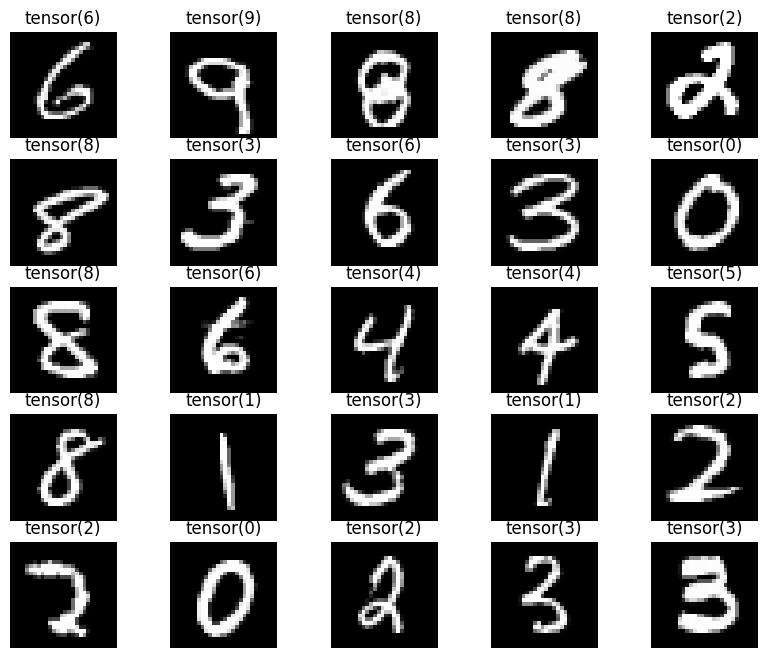

In [23]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [24]:
import matplotlib.pyplot as plt

In [25]:
from torch.utils.data import DataLoader
loaders = {
    'train' : torch.utils.data.DataLoader(train_data,
                                          batch_size=100,
                                          shuffle=True,
                                          num_workers=1),

    'test'  : torch.utils.data.DataLoader(test_data,
                                          batch_size=100,
                                          shuffle=True,
                                          num_workers=1),
}
loaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7a1526677df0>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7a1526677160>}

In [26]:
import torch.nn as nn
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=16,
                kernel_size=5,
                stride=1,
                padding=2,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        # fully connected layer, output 10 classes
        self.out = nn.Linear(32 * 7 * 7, 10)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)
        output = self.out(x)
        return output, x    # return x for visualization

In [27]:
cnn = CNN()
print(cnn)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)


In [28]:
loss_func = nn.CrossEntropyLoss()
loss_func

CrossEntropyLoss()

In [29]:
from torch import optim
optimizer = optim.Adam(cnn.parameters(), lr = 0.01)
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    weight_decay: 0
)

In [30]:
from torch.autograd import Variable
num_epochs = 10
def train(num_epochs, cnn, loaders):

    cnn.train()

    # Train the model
    total_step = len(loaders['train'])

    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(loaders['train']):

            # gives batch data, normalize x when iterate train_loader
            b_x = Variable(images)   # batch x
            b_y = Variable(labels)   # batch y
            output = cnn(b_x)[0]
            loss = loss_func(output, b_y)

            # clear gradients for this training step
            optimizer.zero_grad()

            # backpropagation, compute gradients
            loss.backward()
            # apply gradients
            optimizer.step()

            #if (i+1) % 100 == 0:
        print ('Epoch [{}/{}], Loss: {:.4f}'
                       .format(epoch + 1, num_epochs, loss.item()))



train(num_epochs, cnn, loaders)

Epoch [1/10], Step [100/600], Loss: 0.4374
Epoch [1/10], Step [200/600], Loss: 0.2259
Epoch [1/10], Step [300/600], Loss: 0.4114
Epoch [1/10], Step [400/600], Loss: 0.3419
Epoch [1/10], Step [500/600], Loss: 0.2421
Epoch [1/10], Step [600/600], Loss: 0.2623
Epoch [2/10], Step [100/600], Loss: 0.0696
Epoch [2/10], Step [200/600], Loss: 0.1072
Epoch [2/10], Step [300/600], Loss: 0.1725
Epoch [2/10], Step [400/600], Loss: 0.1643
Epoch [2/10], Step [500/600], Loss: 0.2141
Epoch [2/10], Step [600/600], Loss: 0.1295
Epoch [3/10], Step [100/600], Loss: 0.2244
Epoch [3/10], Step [200/600], Loss: 0.2106
Epoch [3/10], Step [300/600], Loss: 0.1606
Epoch [3/10], Step [400/600], Loss: 0.1002
Epoch [3/10], Step [500/600], Loss: 0.1956
Epoch [3/10], Step [600/600], Loss: 0.0745
Epoch [4/10], Step [100/600], Loss: 0.1383
Epoch [4/10], Step [200/600], Loss: 0.1027
Epoch [4/10], Step [300/600], Loss: 0.1392
Epoch [4/10], Step [400/600], Loss: 0.0819
Epoch [4/10], Step [500/600], Loss: 0.0941
Epoch [4/10

In [31]:
def test():
    # Test the model
    cnn.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in loaders['test']:
            test_output, last_layer = cnn(images)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            accuracy = (pred_y == labels).sum().item() / float(labels.size(0))

    print('Test Accuracy of the model on the 10000 test images: %.2f' % accuracy)


test()

Test Accuracy of the model on the 10000 test images: 0.91


In [32]:
sample = next(iter(loaders['test']))
imgs, lbls = sample

In [33]:
actual_number = lbls[:10].numpy()
actual_number

array([7, 3, 2, 8, 9, 6, 8, 4, 1, 4])

In [34]:
test_output, last_layer = cnn(imgs[:10])
pred_y = torch.max(test_output, 1)[1].data.numpy().squeeze()
print(f'Prediction number: {pred_y}')
print(f'Actual number: {actual_number}')

Prediction number: [7 3 2 8 9 6 8 4 1 6]
Actual number: [7 3 2 8 9 6 8 4 1 4]
